In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

In [2]:
import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline

## Set up and run the microlensing metric. ## 

The microlensing metric is similar to the KNe metric, in that it requires a microlensing-specific slicer (a UserPoints slicer combined with information about the microlensing events and lightcurves) together with the microlensing detection metric. 

The population distribution for the microlensing metric is currently a simple N^2 distribution of events (N being the stellar density at that point in the sky). Events occur with a variety of crossing times, and evaluation of the detection likelilhood in the metric is split up between different intervals; in general longer crossing times are easier to detect and can overwhelm the detection sensitivity to shorter timescale events.

In [3]:
baseline_file = get_baseline()
opsim = os.path.basename(baseline_file).replace('.db','')
opsdb = maf.db.OpsimDatabase(baseline_file)
print(f'running on {opsim}')

running on baseline_nexp2_v1.7_10yrs


In [4]:
metric = maf.MicrolensingMetric()
summaryMetrics = maf.batches.lightcurveSummary()

In [5]:
n_events = 10000 
bundles = {}
# Let's evaluate a variety of crossing times
crossing_times = [[1, 5,], [5, 10], [10, 20], [20, 30], [30, 60], [60, 90], [100, 200], [200, 500], [500, 1000]]
for crossing in crossing_times:
    key = f'{crossing[0]} to {crossing[1]}'
    slicer = maf.generateMicrolensingSlicer(min_crossing_time=crossing[0], max_crossing_time=crossing[1], 
                                            n_events=n_events)
    bundles[key] = maf.MetricBundle(metric, slicer, None, runName=opsim, 
                                            summaryMetrics=summaryMetrics, 
                                            metadata=f'crossing {crossing[0]} to {crossing[1]} days')

In [6]:
outDir = 'test_microlensing'
g = maf.MetricBundleGroup(bundles, opsdb, outDir)

In [7]:
g.runAll()

Querying database SummaryAllProps with no constraint for columns ['filter', 'night', 'rotSkyPos', 'fiveSigmaDepth', 'fieldRA', 'observationStartMJD', 'fieldDec'].
Found 2045493 visits
Running:  ['1 to 5']
Completed metric generation.
Running:  ['5 to 10']
Completed metric generation.
Running:  ['10 to 20']
Completed metric generation.
Running:  ['20 to 30']
Completed metric generation.
Running:  ['30 to 60']
Completed metric generation.
Running:  ['60 to 90']
Completed metric generation.
Running:  ['100 to 200']
Completed metric generation.
Running:  ['200 to 500']
Completed metric generation.
Running:  ['500 to 1000']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [8]:
bundles.keys()

dict_keys(['1 to 5', '5 to 10', '10 to 20', '20 to 30', '30 to 60', '60 to 90', '100 to 200', '200 to 500', '500 to 1000'])

## Look at the metric outputs. ##

The microlensing metric can output two different kinds of results; if 'detect' is True (the default), then it outputs 0-1 depending on whether an event was detected or not.

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


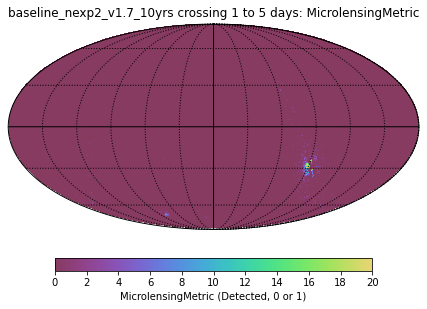

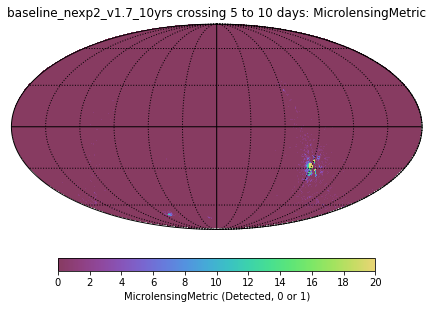

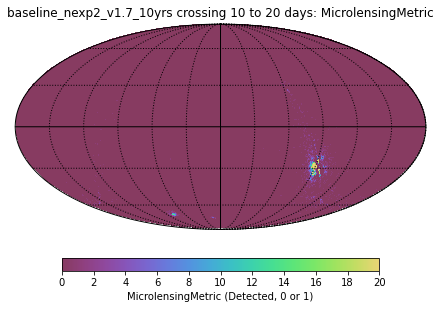

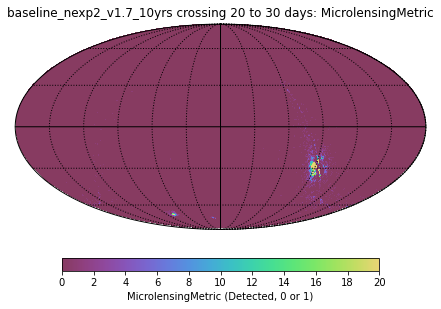

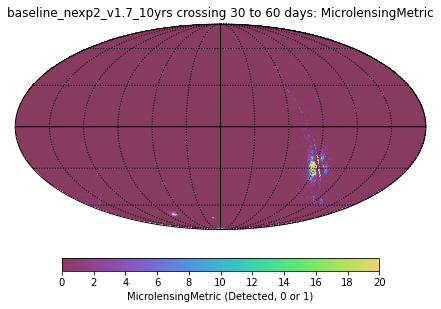

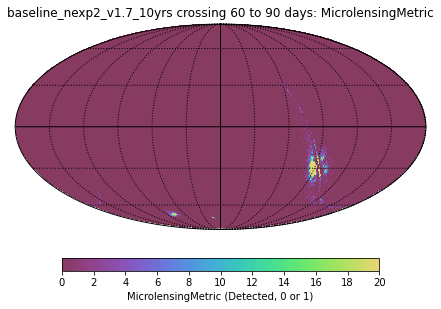

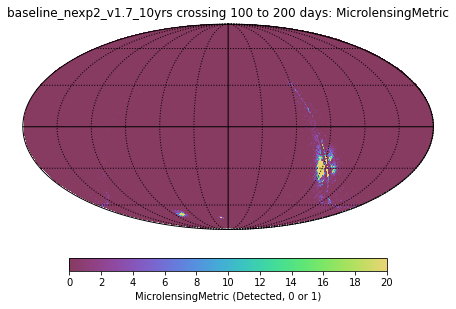

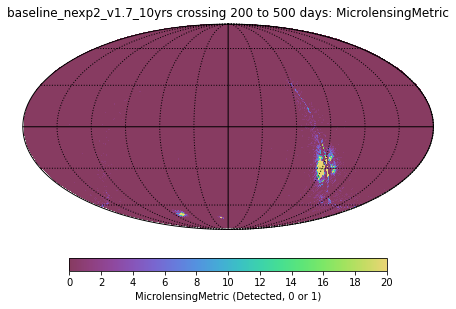

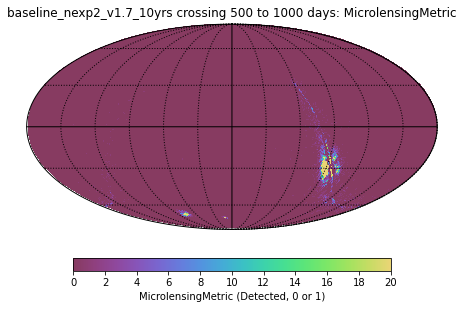

In [9]:
# If you don't want to try and plot N individual points, 
plotDict = {'reduceFunc': np.sum, 'nside': 64, 'colorMin': 0, 'colorMax': 20}
plotFunc = maf.plots.HealpixSkyMap()
ph = maf.plots.PlotHandler(outDir=outDir, figformat='png', thumbnail=False)
for k in bundles:
    ph.setMetricBundles([bundles[k]])
    ph.plot(plotFunc=plotFunc, plotDicts=plotDict)

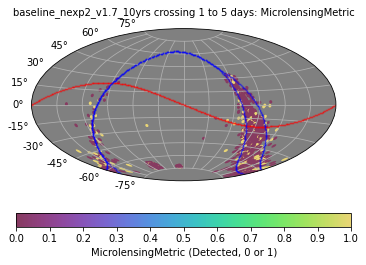

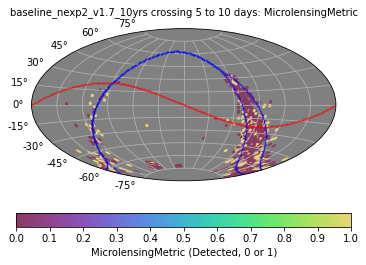

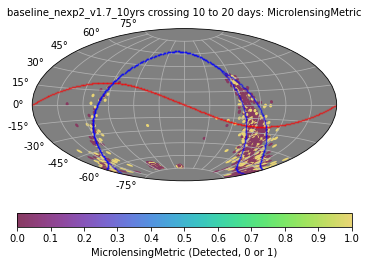

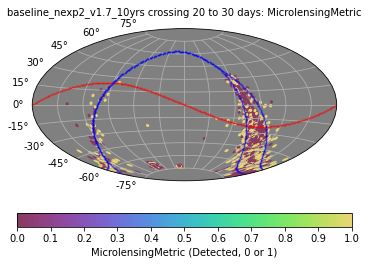

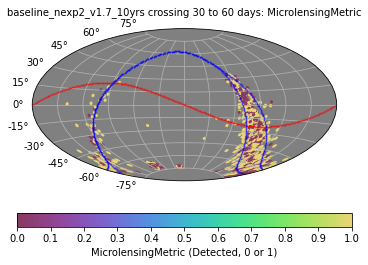

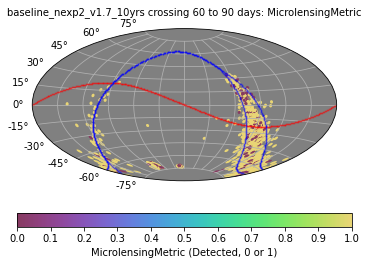

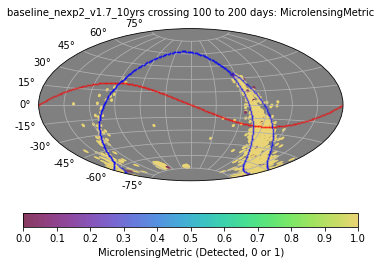

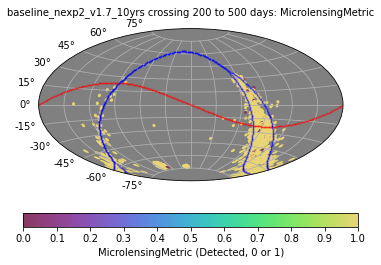

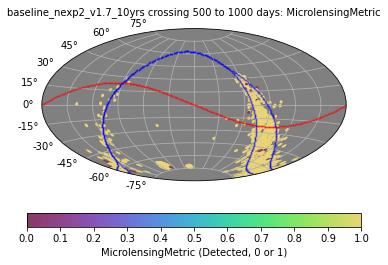

In [10]:
# If you do want to show each individual point - this is slower but shows each individual event
plotFunc = maf.plots.BaseSkyMap()

ph = maf.plots.PlotHandler(outDir=outDir, figformat='png', thumbnail=False)
for k in bundles:
    ph.setMetricBundles([bundles[k]])
    ph.plot(plotFunc=plotFunc)

In [11]:
d = pd.DataFrame([bundles[k].summaryValues for k in bundles.keys()], index=list(bundles.keys()))
d

,Total detected,Total lightcurves in footprint,Total lightcurves on sky,Fraction detected in footprint (mean),Fraction detected of total (mean)
1 to 5,1117.0,9992,10000,0.111789,0.1117
5 to 10,1822.0,9992,10000,0.182346,0.1822
10 to 20,2547.0,9992,10000,0.254904,0.2547
20 to 30,3357.0,9992,10000,0.335969,0.3357
30 to 60,5042.0,9992,10000,0.504604,0.5042
60 to 90,7388.0,9992,10000,0.739392,0.7388
100 to 200,9667.0,9992,10000,0.967474,0.9667
200 to 500,9714.0,9992,10000,0.972178,0.9714
500 to 1000,9459.0,9992,10000,0.946657,0.9459


Text(0.5, 1.0, 'Total detected / 10000 as function of crossing time')

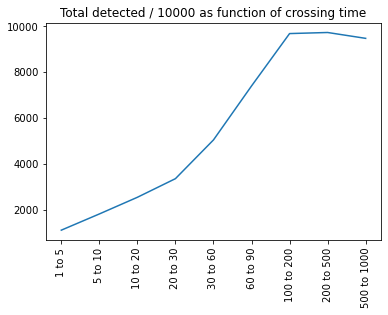

In [12]:
plt.plot(d['Total detected'])
plt.xticks(rotation=90)
plt.title(f'Total detected / {n_events} as function of crossing time')

In [13]:
# Illustrate some things about the metric values: (caught in summary metrics)
m = list(bundles.keys())[-1]
print(f'How many lightcurves were added? (over the entire sky) {len(bundles[m].metricValues)}')
print(f'How many lightcurves were added in areas that were part of the survey footprint?' ,
      f'{len(bundles[m].metricValues.compressed())}')
print(f'What are the metric values for each of these light curves? '
      f'{np.unique(bundles[m].metricValues.compressed())}')
print(f'How many lightcurves were *successfully* detected? {bundles[m].metricValues.sum()}')
print(len(np.where(bundles[m].metricValues == 1)[0]))
frac_total = bundles[m].metricValues.sum() / len(bundles[m].metricValues)
print(f'Fraction of total lightcurves detected {frac_total}')
frac_footprint = bundles[m].metricValues.sum() / len(bundles[m].metricValues.compressed())
print(f'Fraction of lightcurves within footprint detected {frac_footprint}')

How many lightcurves were added? (over the entire sky) 10000
How many lightcurves were added in areas that were part of the survey footprint? 9992
What are the metric values for each of these light curves? [0. 1.]
How many lightcurves were *successfully* detected? 9459.0
9459
Fraction of total lightcurves detected 0.9459
Fraction of lightcurves within footprint detected 0.9466573258606885


## Look at the slicer information (how the lightcurves were added). ##

In [14]:
# The *slicer* keeps the information about the injected lightcurves too
slicer = bundles[m].slicer
print(f'How many lightcurves added over the sky? {len(slicer)}')

How many lightcurves added over the sky? 10000


In [15]:
# What information was recorded for each event
slicer.slicePoints.keys()

dict_keys(['sid', 'ra', 'dec', 'peak_time', 'crossing_time', 'impact_parameter'])

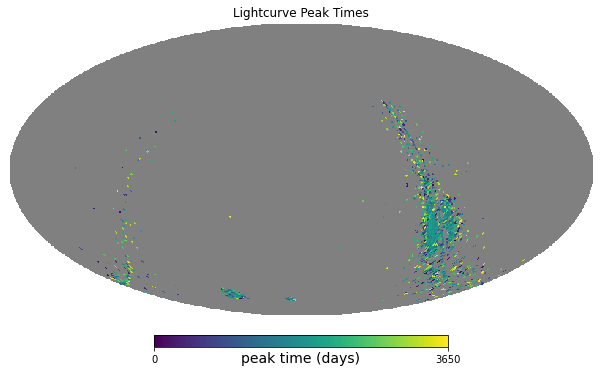

In [16]:
# Including their spatial, time and distance distribution
hp.mollview(rsUtils._healbin(slicer.slicePoints['ra'], slicer.slicePoints['dec'], 
                             slicer.slicePoints['peak_time'], 64, reduceFunc=np.mean), 
            unit='peak time (days)', title='Lightcurve Peak Times', min=0, max=3650)